# Гипотеза

Если заменить выбросы в диапазоне  $754*0.8>𝑥>963*1.2$ на значения в предыдущей точке, то качество метрики может улучшиться.  
Лучшее значение метрики f1 binary на текущий момент = 0.8072364316905803 (см. [cardiospike-pipeline](https://github.com/mmezhov/cardiospike/blob/main/pipelines/cardiospike-pipeline.ipynb))  

>**уточнение**  
сделаем замену min_rr = 754\*0.8 = 603.2 на 460, чтобы не терять в разметке аномальных точек
возможно снижение уровня ниже нормы обусловлено больнезнью человека, 
т.е. влиянием ухудшеного состояния его организма на снижение медианного значения ритмограммы

>**итог**  
>по среднему значению метрики есть небольшое улучшение:  
>test_score: [0.79899339 0.69926393 0.56414104 0.75621265 0.76210153]  
>mean test_score = 0.7161425084850291  
>
>в [cardiospike-pipeline](https://github.com/mmezhov/cardiospike/blob/main/pipelines/cardiospike-pipeline.ipynb):  
>test_score: [0.80723643 0.69782095 0.55931778 0.75157233 0.76404494]  
>mean test_score = 0.7159984871459176

Гипотеза возникла после ознакомления со следующей таблицей на стр.68 из [книги по вариабельности сердечного ритма](https://core.ac.uk/download/pdf/46586473.pdf):

<img src='norm.jpg' width='80%'></img>

In [4]:
import pandas as pd
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import f1_score

In [22]:
# Const
RANDOM_STATE = 0
# min_rr = 754*0.8
min_rr = 460  # снижаю границу, чтобы не терять аномальных точек
max_rr = 963*1.2

print(min_rr, '/', max_rr)

460 / 1155.6


# Полезные методы

In [8]:
def make_XY(df):
    """
    df: dataset
    return:
    X: numpy array with features, values are scaled
    y: numpy array of target labels
    """
    X = df.drop(['y','id','time'], axis=1)
    y = df.y.to_numpy()

    scaler = StandardScaler().fit(X.to_numpy())
    X = scaler.transform(X.to_numpy())

    with open('scaler_hypothesis_3.pkl', 'wb') as f:
        pickle.dump(scaler, f)
        
    print('scaler_hypothesis_3.pkl was saved in output directory')

    return X, y


def get_train_test_indexes(X,y):
    """
    X,y: numpy arrays with features and target
    return stratified indexes:
        train_indexes: indexes for train data
        test_indexes: indexes for test data
    """
    skf = StratifiedKFold()
    folds = dict()
    for i, (train_indexes, test_indexes) in enumerate(skf.split(X,y)):
        folds[i] = {
            'train_indexes': train_indexes,
            'test_indexes': test_indexes
        }
    return folds[0]['train_indexes'].tolist(), folds[0]['test_indexes'].tolist()


def plot_RR(rr_ids, data):
    """
    Рисует графики ритмограмм с разметкой аномальных участков
    rr_ids: список идентификаторов ритмограмм
    data: набор данных
    """
    df = data.set_index('time').copy()
    for rr_id in rr_ids:
        fig = plt.figure(figsize=(20,5))
        plt.title(f'R-R №{rr_id}')
        plt.plot(df[df.id == rr_id].x, '-o', zorder=1)
        df_anomaly = df[(df.id == rr_id)&(df.y == 1)].reset_index()
        df_anomaly['time-diff'] = df_anomaly.time.diff()
        split_indexes = df_anomaly[df_anomaly['time-diff'] > 1000].index
        split_indexes = list(split_indexes)
        split_indexes.append(0)
        split_indexes.sort()
        len_spl = len(split_indexes)
        for i in range(len_spl):
            if i == len_spl-1:
                mask = (df_anomaly.index >= split_indexes[i])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                     label='аномальный участок', color='red', zorder=2)
            else:
                mask = (df_anomaly.index >= split_indexes[i])&(df_anomaly.index < split_indexes[i+1])
                plt.plot(df_anomaly[mask].time, df_anomaly[mask].x, '-o',
                         color='red', zorder=2)
        plt.legend()
        plt.xlabel('R-R timeline, ms')
        plt.ylabel('R-R interval')
        plt.show()

# Подготовка датасета

In [28]:
df = pd.read_csv('../input/cardiospikecompetition/train.csv')
ids = df.id.unique()
for rr_id in ids:
    mask = (df.id==rr_id)
    df.loc[mask, 'x_diff'] = df[mask].x.diff()
    df.loc[mask, 'x_deviation_median'] = df[mask].x.median() - df[mask].x.values
    for i in range(1,5):
        # добавим в признаки 4 следующие точки
        df.loc[mask, f'x+{i}'] = df[mask].x.shift(-i)
        # и 4 предыдущие точки
        df.loc[mask, f'x-{i}'] = df[mask].x.shift(i)
    df.loc[mask, 'x-(x+1)'] = df[mask].x.values - df.loc[mask, 'x+1'].values
    df.loc[mask, 'x-(x+2)'] = df[mask].x.values - df.loc[mask, 'x+2'].values
    df.loc[mask, 'x-(x-2)'] = df[mask].x.values - df.loc[mask, 'x-2'].values
    df.loc[mask, 'x-(x+3)'] = df[mask].x.values - df.loc[mask, 'x+3'].values
    df.loc[mask, 'x-(x-3)'] = df[mask].x.values - df.loc[mask, 'x-3'].values
    df.loc[mask, 'x-(x+4)'] = df[mask].x.values - df.loc[mask, 'x+4'].values
    df.loc[mask, 'x-(x-4)'] = df[mask].x.values - df.loc[mask, 'x-4'].values

In [29]:
print('TEST')
print('- всего ритмограмм в наборе данных', len(df.id.unique()), 'штук\n')
print('- в каждой ритмограмме первые и последние 4 строки \n' \
       'будут с пропусками из-за отсутствия данных о прошлых и будущих точках для \n' \
      'первых и последних 4 точек в радиограмме,\n' \
      'следовательно строк с пропусками должно быть', len(df.id.unique())*8, '\n')
print('- финальный размер датасета должне быть', len(df)-len(df.id.unique())*8, '\n')

print('смотрим, что получается по факту:')
print('df', len(df))
print('df.dropna', len(df.dropna()))
print('разница', len(df) - len(df.dropna()))
if (len(df)-len(df.id.unique())*8 == len(df.dropna())):
    print('Итог: по размеру датасет соответствует ожидаемому, ' \
          'нужно ещё выбрать контрольный пример для оценки глазами')
    print(':)')
else:
    print('Итог: по размерности не сходится... ' \
          'надо проверить алгоритм добавления признаков')
    print(':(')

TEST
- всего ритмограмм в наборе данных 229 штук

- в каждой ритмограмме первые и последние 4 строки 
будут с пропусками из-за отсутствия данных о прошлых и будущих точках для 
первых и последних 4 точек в радиограмме,
следовательно строк с пропусками должно быть 1832 

- финальный размер датасета должне быть 58655 

смотрим, что получается по факту:
df 60487
df.dropna 58655
разница 1832
Итог: по размеру датасет соответствует ожидаемому, нужно ещё выбрать контрольный пример для оценки глазами
:)


In [30]:
df.dropna(inplace=True)

In [31]:
# проверим сколько точек будет распознано как выбросы и нет ли в них точек с у=1
df[(df.x > max_rr)|(df.x < min_rr)].y.value_counts()

0    11098
Name: y, dtype: int64

под удаление попадают аномальные точки...  
посмотрим что на графиках по id: 13, 29, 109

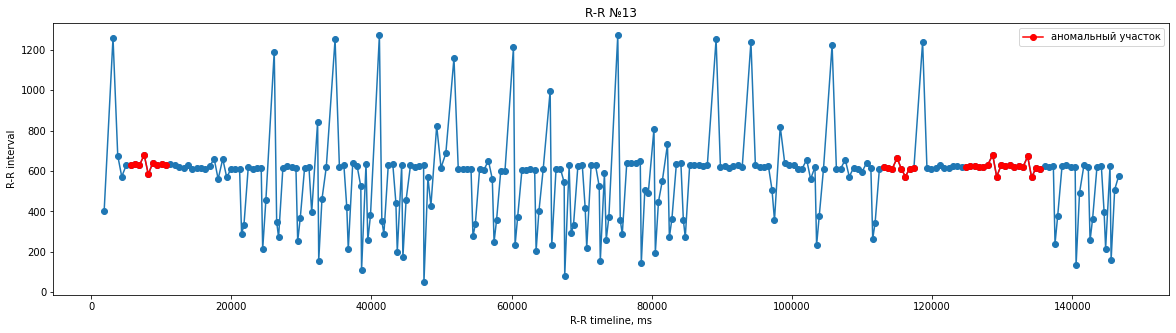

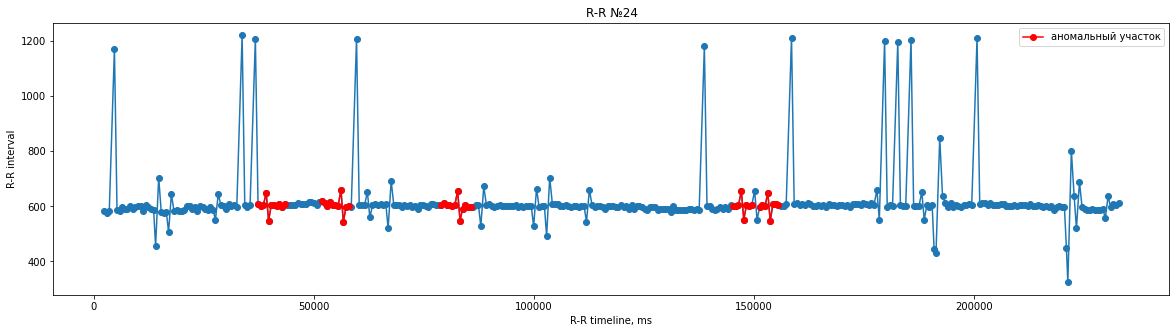

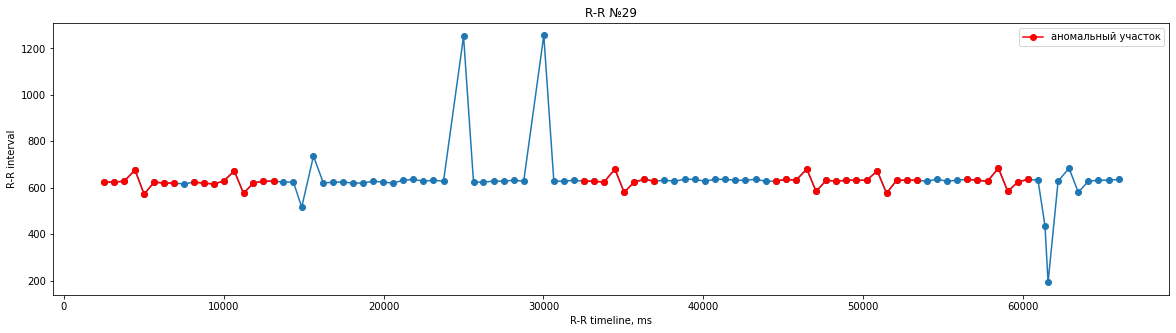

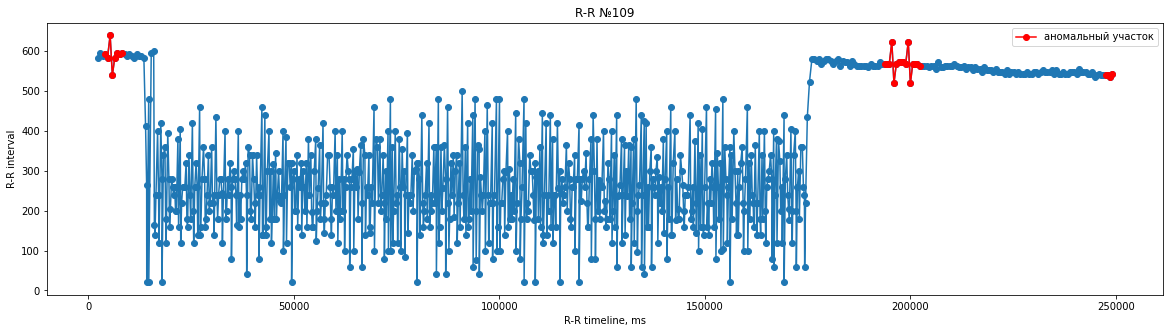

In [32]:
plot_RR([13, 24, 29,109], df)

In [33]:
# проверим сколько точек будет распознано как выбросы и нет ли в них точек с у=1
df[(df.x > max_rr)|(df.x < 460)].y.value_counts()

0    11098
Name: y, dtype: int64

>сделаем замену min_rr с 603.2 на 460, чтобы не терять в разметке аномальных точек  
>возможно снижение уровня ниже нормы обусловлено больнезнью человека, т.е. влиянием ухудшеного состояния его организма на снижение медианного значения ритмограммы

# Замена выбросов

In [34]:
print(f'количество выбрасов выше {max_rr} =', len(df[df.x > max_rr]))
print(f'количество выбрасов ниже {min_rr} =', len(df[df.x < min_rr]))

количество выбрасов выше 1155.6 = 972
количество выбрасов ниже 460 = 10126


In [35]:
out_cnt = len(df[(df.x > max_rr)|(df.x < min_rr)].y)
df.loc[df.x > max_rr, 'x'] = pd.NA
df.loc[df.x < min_rr, 'x'] = pd.NA

print('количество NA после мьютирования =', len(df[df.x.isna()]))
if len(df[df.x.isna()]) == out_cnt:
    print('выбросы замьютированы корректно')
else:
    print('мьютирование выбросов прошло некорректно...')

количество NA после мьютирования = 11098
выбросы замьютированы корректно


In [36]:
# индексы, которые были выялены как выбросы
out_ind = df[df.x.isna()].index

In [40]:
# test
df.x.ffill(inplace=True)
# проверка на корректность мьютирования
ind = np.random.randint(len(out_ind))
display(df.loc[[out_ind[ind]-1, out_ind[ind]], 'x'])
if df.loc[out_ind[ind]-1, 'x'] == df.loc[out_ind[ind], 'x']:
    print('\nПроверка прошла успешно! :)')
else:
    print('\nДанные в соседних точках не совпадают... :(')

34583    656
34584    656
Name: x, dtype: int64


Проверка прошла успешно! :)


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58655 entries, 4 to 60482
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  58655 non-null  int64  
 1   time                58655 non-null  int64  
 2   x                   58655 non-null  int64  
 3   y                   58655 non-null  int64  
 4   x_diff              58655 non-null  float64
 5   x_deviation_median  58655 non-null  float64
 6   x+1                 58655 non-null  float64
 7   x-1                 58655 non-null  float64
 8   x+2                 58655 non-null  float64
 9   x-2                 58655 non-null  float64
 10  x+3                 58655 non-null  float64
 11  x-3                 58655 non-null  float64
 12  x+4                 58655 non-null  float64
 13  x-4                 58655 non-null  float64
 14  x-(x+1)             58655 non-null  float64
 15  x-(x+2)             58655 non-null  float64
 16  x-(x

In [42]:
# сохраним датасет в с текущими признаками, предварительно удалив строки с пропусками
with open('dataset_hypothesis_4.pkl', 'wb') as f:
    pickle.dump(df, f)
    
df.to_csv('dataset_hypothesis_4.csv')

# X, y

In [43]:
# make X and y
X,y = make_XY(df)

scaler_hypothesis_3.pkl was saved in output directory


# Cross validation

In [44]:
model = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)

cv_result = cross_validate(model, X, y, cv=StratifiedKFold(), scoring='f1')

print('test_score:', cv_result['test_score'])
print('mean test_score =', cv_result['test_score'].mean())
print('current best mean test_score = 0.7159984871459176')

test_score: [0.79899339 0.69926393 0.56414104 0.75621265 0.76210153]
mean test_score = 0.7161425084850291
current best mean test_score = 0.7159984871459176


>по среднему значению метрики есть небольшое улучшение,  
>в [cardiospike-pipeline](https://github.com/mmezhov/cardiospike/blob/main/pipelines/cardiospike-pipeline.ipynb):  
>test_score: [0.80723643 0.69782095 0.55931778 0.75157233 0.76404494]  
>mean test_score = 0.7159984871459176